In [13]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, GlobalAveragePooling1D, 
                                     ReLU, Multiply, LSTM, Dense, BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tabulate import tabulate
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Load CSV
data_path = 'plant_health_datawithnomalization.csv'
data = pd.read_csv(data_path)

# Features and Target
X = data[['Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature', 'Humidity',
          'Light_Intensity', 'Soil_pH', 'Nitrogen_Level', 'Phosphorus_Level',
          'Potassium_Level', 'Chlorophyll_Content', 'Electrochemical_Signal']]
y = data['Plant_Health_Status']

# Convert to numpy arrays
X = X.values
y = y.values

# Reshape X ให้เหมาะกับ Conv1D (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
# Split data into train (70%) and temporary (30% for test + validate)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split temporary data into test (20%) and validate (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)  # 33.33% of 30% ≈ 10%


In [15]:
def create_and_train_model(learning_rate):
    # Define the model
    input_seq = Input(shape=(X.shape[1], 1))

    # Left side: Conv_1 → ReLU_1 → Conv_2 → ReLU_2
    conv_1 = Conv1D(filters=128, kernel_size=3, padding='same')(input_seq)
    conv_1 = BatchNormalization()(conv_1)  # Add Batch Normalization
    relu_1 = ReLU()(conv_1)
    dropout_1 = Dropout(0.2)(relu_1)  

    conv_2 = Conv1D(filters=128, kernel_size=3, padding='same')(dropout_1)
    conv_2 = BatchNormalization()(conv_2)  # Add Batch Normalization
    relu_2 = ReLU()(conv_2)
    dropout_2 = Dropout(0.2)(relu_2)  

    # Right side: Conv_1 → Global Pooling → Fc_2 → ReLU_3 → Fc_3 → Sigmoid
    global_pool = GlobalAveragePooling1D()(conv_1)
    fc_2 = Dense(128)(global_pool)
    relu_3 = ReLU()(fc_2)
    dropout_3 = Dropout(0.2)(relu_3)
    fc_3 = Dense(128)(dropout_3)
    sigmoid = Dense(128, activation='sigmoid')(fc_3)

    # Multiply both sides
    multiply = Multiply()([dropout_2, sigmoid])

    # LSTM × 6
    lstm = LSTM(256, return_sequences=True)(multiply)
    for _ in range(4):  
        lstm = LSTM(256, return_sequences=True)(lstm)
    lstm = LSTM(256, return_sequences=False)(lstm)  

    # Fully Connected Layer
    fc = Dense(128, activation='relu')(lstm)
    dropout_4 = Dropout(0.2)(fc)  

    # Regression Output
    output = Dense(1)(dropout_4)

    # Create model
    model = Model(inputs=input_seq, outputs=output)

    # Define optimizer with learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(optimizer=optimizer, loss='mse')

    return model


In [16]:
def train_and_evaluate_model(model, learning_rate):

    # เทรนโมเดลพร้อม Early Stopping
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=8,
        validation_data=(X_test, y_test),
        verbose=1,
    )

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Learning Curve (LR={learning_rate})')
    plt.legend()
    plt.grid()
    plt.show()

    # ทำนายผลลัพธ์
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # คำนวณ Metrics
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mbe_train = np.mean(y_train - y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mbe_test = np.mean(y_test - y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return [learning_rate, r2_test, mae_test, mbe_test, rmse_test, 
            r2_train, mae_train, mbe_train, rmse_train]


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.9730 - val_loss: 1.0090
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3151 - val_loss: 0.7910
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.3267 - val_loss: 0.6085
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.3125 - val_loss: 0.4839
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2824 - val_loss: 0.3925
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.2613 - val_loss: 0.4910
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.2859 - val_loss: 0.5255
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.2666 - val_loss: 0.3234
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2516 - val_loss: 0.4177
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.3024 - val_loss: 0.3296
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.2623 - val_loss: 0.3431
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/st

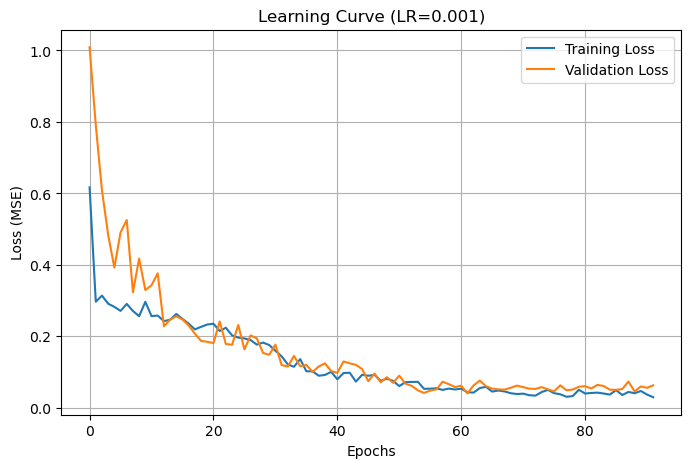

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
+-----------------+-----------+------------+------------+-------------+------------+-------------+-------------+--------------+
|   Learning Rate |   Test R² |   Test MAE |   Test MBE |   Test RMSE |   Train R² |   Train MAE |   Train MBE |   Train RMSE |
+=================+===========+============+============+=============+============+=============+=============+==============+
|           0.001 |  0.935959 |   0.127442 | 0.00287846 |    0.200952 |   0.973678 |   0.0902234 |   0.0269453 |     0.129669 |
+-----------------+-----------+------------+------------+-------------+------------+-------------+-------------+--------------+


In [17]:
# ทดสอบด้วย Learning Rate ต่าง ๆ
learning_rates = [0.001]

results = []
for lr in learning_rates:
    model = create_and_train_model(lr)
    result = train_and_evaluate_model(model, lr)
    results.append(result)

# แสดงผลเป็นตาราง
headers = ["Learning Rate", "Test R²", "Test MAE", "Test MBE", "Test RMSE",
           "Train R²", "Train MAE", "Train MBE", "Train RMSE"]
print(tabulate(results, headers=headers, tablefmt="grid"))

df_results = pd.DataFrame(results, columns=headers)
df_results.to_csv("model_results.csv", index=False)